# NYC Crime Trends:
### What are the primary factors influencing crime?
**Main Dataset:** https://www.kaggle.com/datasets/mrmorj/new-york-city-police-crime-data-historic

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
pd.set_option('display.max_columns', None)

In [2]:
crime_data = pd.read_csv('Full_crimedata_with_zip.csv', dtype={'ZIP': str})

## Location-Based Trends

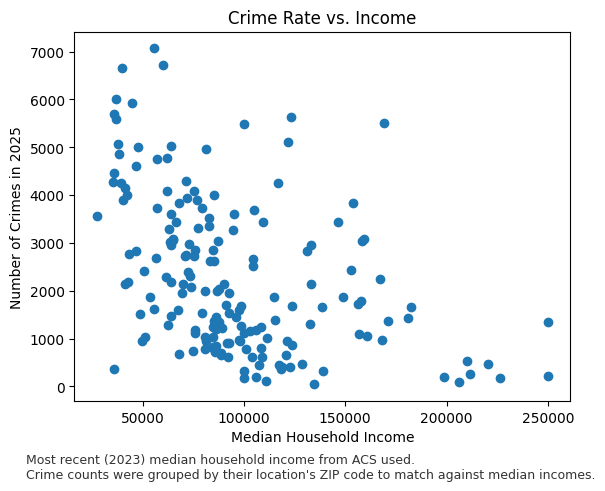

In [33]:
with open('zip_median.json', 'r') as file:
  zip_median = json.load(file)

x_vals = []
y_vals = []
for zip, income in zip_median.items():
  crime_count = len(crime_data[crime_data['ZIP'] == zip])
  x_vals.append(income)
  y_vals.append(crime_count)
plt.scatter(x_vals, y_vals)
plt.title('Crime Rate vs. Income')
plt.xlabel('Median Household Income')
plt.ylabel('Number of Crimes in 2025')
plt.figtext(
  0.05, -.05,
  'Most recent (2023) median household income from ACS used.\n' +
  'Crime counts were grouped by their location\'s ZIP code to match against median incomes.',
  fontsize=9, c='#333333'
);

Crimes are more likely to happen in areas with lower household incomes.

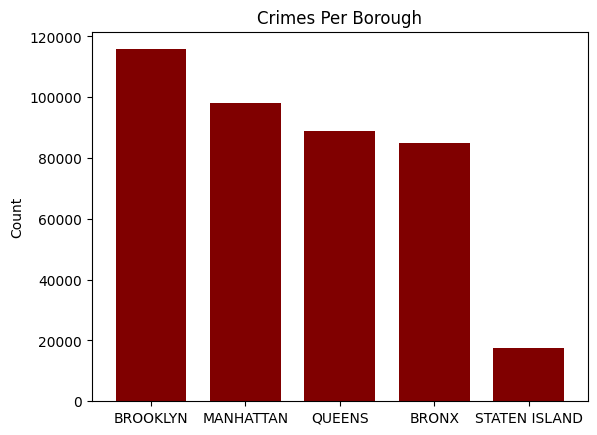

In [139]:
counts = crime_data['BORO_NM'].value_counts();
del counts['(null)']
counts.plot(kind='bar', width=.75, color='maroon')
plt.xticks(rotation=0)
plt.title('Crimes Per Borough')
plt.xlabel('')
plt.ylabel('Count');

Somewhat more crimes happen in Brooklyn compared to other boroughs, though the first four are fairly similar. Staten Island has a much lower crime rate compared to the first four.

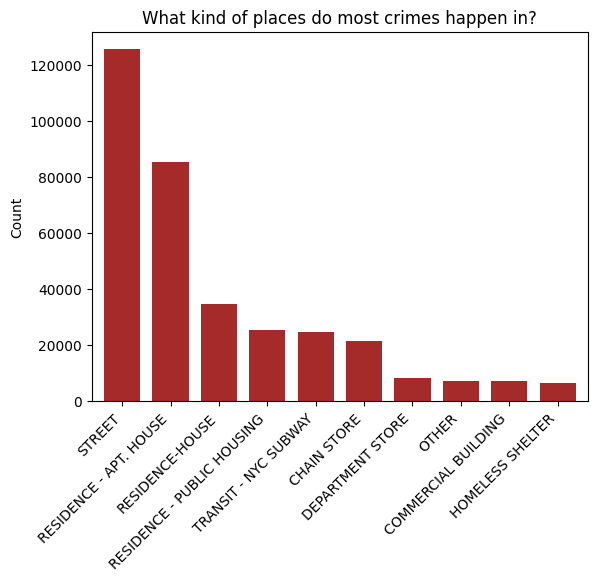

In [142]:
crime_data['PREM_TYP_DESC'].value_counts()[:10].plot(kind='bar', width=.75, color='brown')
plt.xticks(rotation=45, ha='right')
plt.title('What kind of places do most crimes happen in?')
plt.xlabel('')
plt.ylabel('Count');

## Time-Based Trends

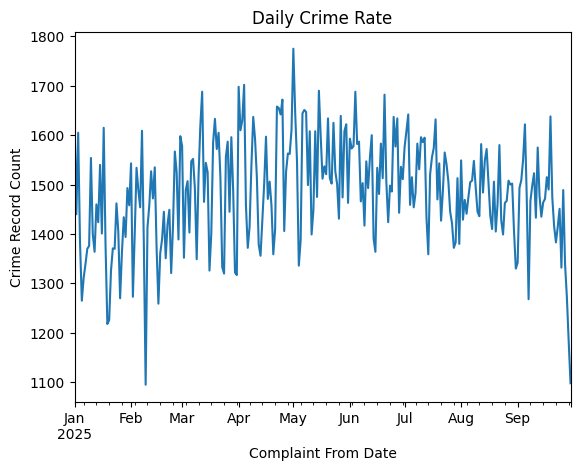

In [11]:
pd.to_datetime(crime_data['CMPLNT_FR_DT']).value_counts().sort_index().plot(kind='line')
plt.title('Daily Crime Rate')
plt.xlabel('Complaint From Date')
plt.ylabel('Crime Record Count')
plt.axvline();

More crimes happened overall around the summer compared to other seasons, spiking on May. 

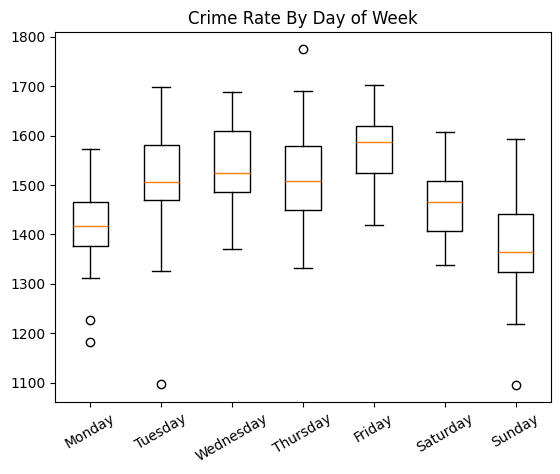

In [31]:
date_crimes = pd.to_datetime(crime_data['CMPLNT_FR_DT']).value_counts().sort_index()
dayweek_count = [(t.dayofweek, c) for t, c in date_crimes.items()]
plt.boxplot([[c for t, c in dayweek_count if t == i] for i in range(0,7)])
import calendar

day_names = [calendar.day_name[i] for i in range(7)] 
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7], labels=day_names, rotation=30)
plt.title('Crime Rate By Day of Week');

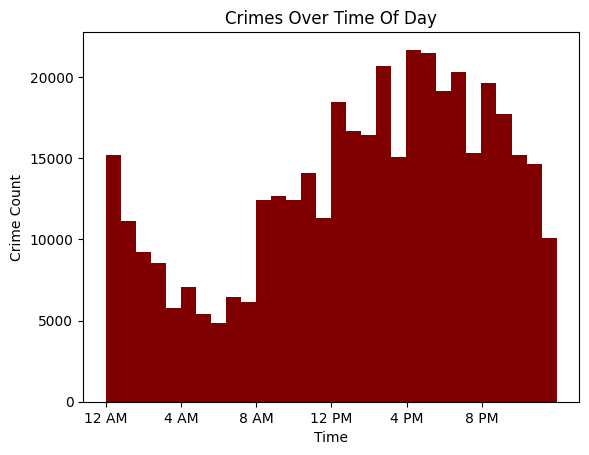

In [88]:
def time_to_seconds(time):
  return np.array(time.split(':'), dtype=int) @ [3600, 60, 1]

times = [time_to_seconds(t) for t in crime_data['CMPLNT_FR_TM']]
plt.hist(times, bins=30, color='maroon')
plt.title('Crimes Over Time Of Day')
plt.xticks(
  np.array([0, 1, 2, 3, 4, 5]) * (86400/6),
  ['12 AM', '4 AM', '8 AM', '12 PM', '4 PM', '8 PM']
);
plt.xlabel('Time')
plt.ylabel('Crime Count');

In NYC, crimes are least likely to happen at early hours in general.

## Victim/Suspect Identity

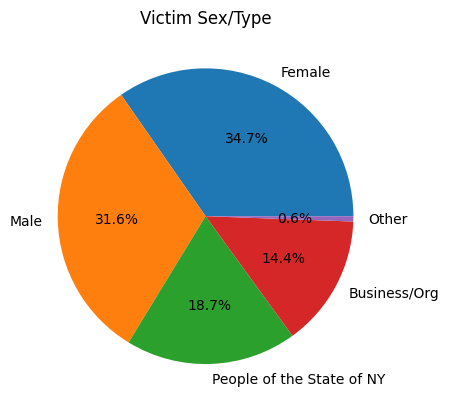

In [ ]:
counts = crime_data['VIC_SEX'].value_counts()
sex_map = {'M': 'Male', 'F': 'Female', 'E': 'People of the State of NY', 'D': 'Business/Org', 'L': 'Other'}
plt.pie(counts, labels=counts.index.map(sex_map), autopct='%1.1f%%')
plt.title('Victim Sex/Type');

There is not a strong correlation here indicating one sex is more likely to be a victim of a crime over another.

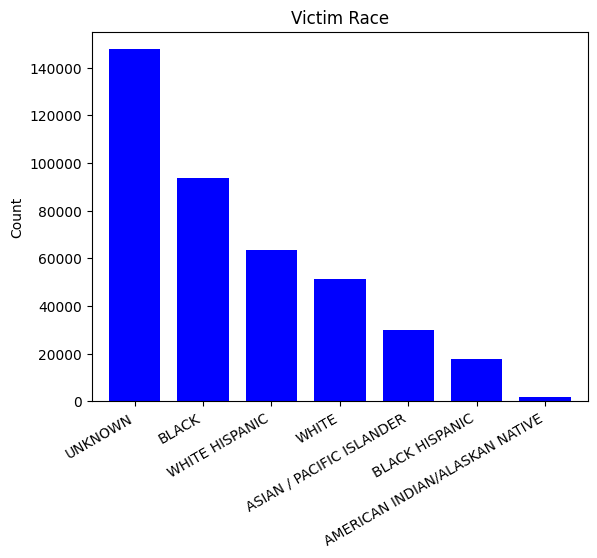

In [161]:
counts = crime_data['VIC_RACE'].value_counts()
del counts['(null)']
counts.plot(kind='bar', width=.75, color='blue')
plt.xticks(rotation=30, ha='right')
plt.title('Victim Race')
plt.xlabel('')
plt.ylabel('Count');

Blacks and white hispanics are disproportionately victims of crime in NYC.

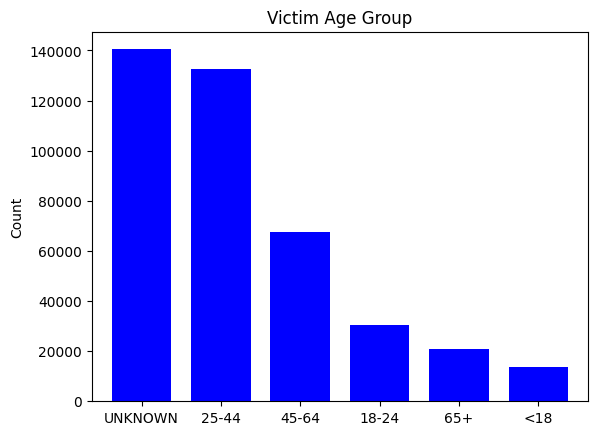

In [ ]:
counts = crime_data['VIC_AGE_GROUP'].value_counts()
counts = counts[counts > 2]
counts.plot(kind='bar', width=.75, color='blue')
plt.xticks(rotation=0, ha='center')
plt.title('Victim Age Group')
plt.xlabel('')
plt.ylabel('Count');

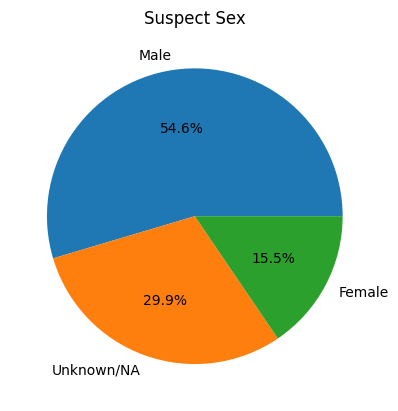

In [156]:
counts = crime_data['SUSP_SEX'].value_counts()
counts['U'] += counts['(null)']
del counts['(null)']
sex_map = {'M': 'Male', 'F': 'Female', 'U': 'Unknown/NA'}
plt.pie(counts, labels=counts.index.map(sex_map), autopct='%1.1f%%')
plt.title('Suspect Sex');

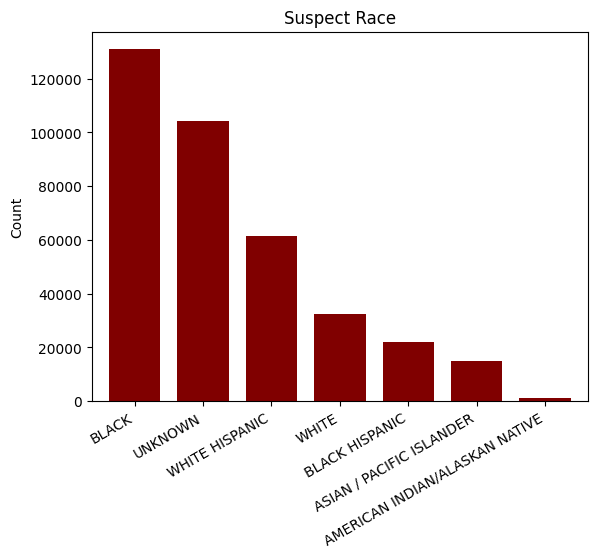

In [163]:
counts = crime_data['SUSP_RACE'].value_counts()
del counts['(null)']
counts.plot(kind='bar', width=.75, color='maroon')
plt.xticks(rotation=30, ha='right')
plt.title('Suspect Race')
plt.xlabel('')
plt.ylabel('Count');

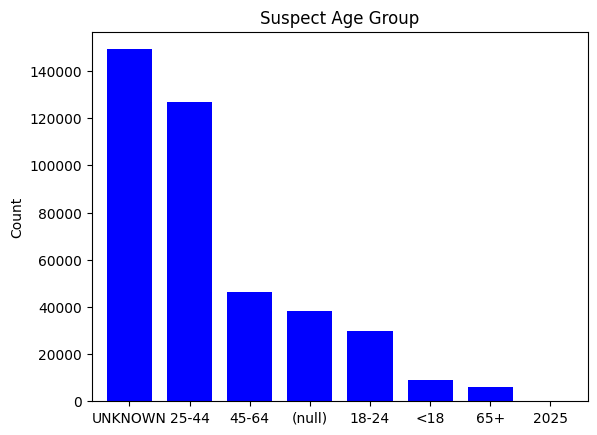

In [30]:
counts = crime_data['SUSP_AGE_GROUP'].value_counts()
counts = counts[counts > 2]
counts.plot(kind='bar', width=.75, color='blue')
plt.xticks(rotation=0, ha='center')
plt.title('Suspect Age Group')
plt.xlabel('')
plt.ylabel('Count');

The distribution of suspect races is actually quite similar to the distribution of victim races.

## What kinds of crime?

Text(0.5, 0, '')

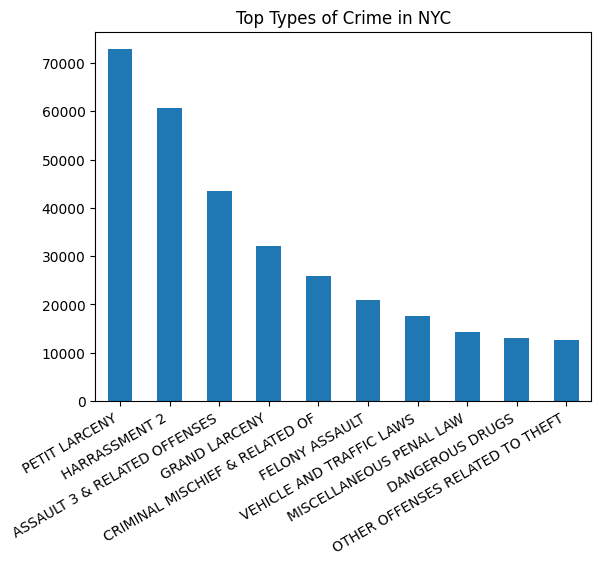

In [10]:
crime_data['OFNS_DESC'].value_counts()[:10].plot(kind='bar')
plt.xticks(rotation=30, ha='right')
plt.title('Top Types of Crime in NYC')
plt.xlabel('')

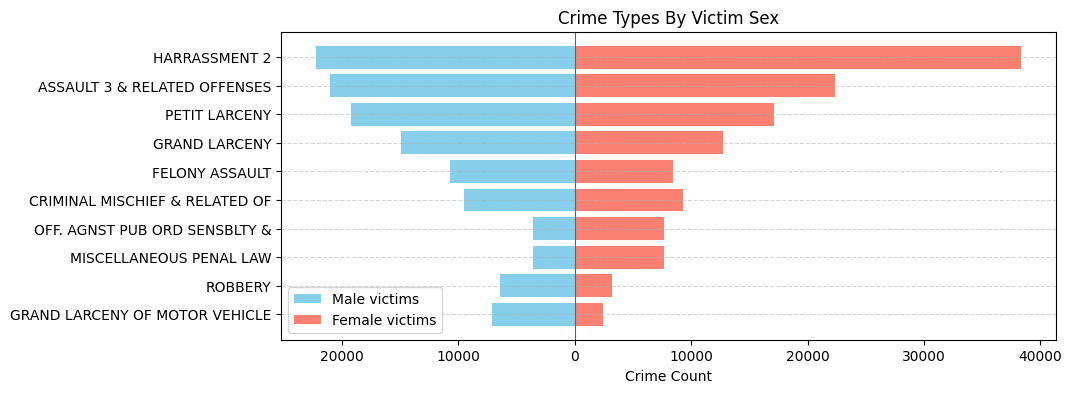

In [28]:
def compare_male_female(category, category_upper):
  filtered = crime_data[crime_data[category].isin(('F', 'M'))]
  types = filtered['OFNS_DESC'].value_counts()[:10][::-1]
  male = filtered[filtered[category] == 'M']['OFNS_DESC'].value_counts()
  female = filtered[filtered[category] == 'F']['OFNS_DESC'].value_counts()

  top_types = types.index.tolist()
  male_counts_rev = [-male.get(t, 0) for t in top_types]
  female_counts = [female.get(t, 0) for t in top_types]
  
  plt.figure(figsize=(10,4))
  
  y_pos = np.arange(len(top_types))
  plt.barh(y_pos, male_counts_rev, color='skyblue', label='Male victims')
  plt.axvline(0, linewidth=0.8)
  plt.barh(y_pos, female_counts, color='salmon', label='Female victims')
  plt.grid(axis='y', linestyle='--', alpha=0.5)
  plt.yticks(y_pos, top_types)

  plt.title(f'Crime Types By {category_upper} Sex')
  plt.xlabel('Crime Count')
  plt.legend()

  # Make the x tick labels positive both directions from 0
  ticks, ticklabels = plt.xticks()
  plt.xticks(ticks[1:-1], [t.get_text().removeprefix('−') for t in ticklabels[1:-1]]);

compare_male_female('VIC_SEX', 'Victim')

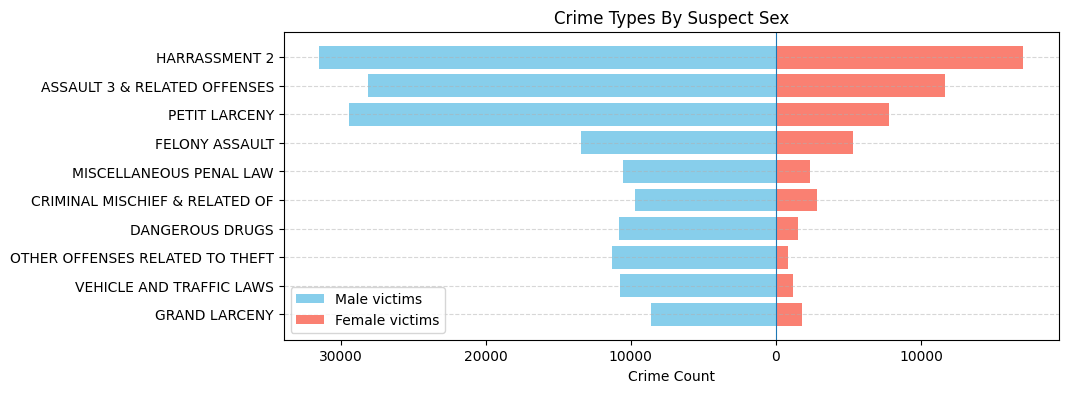

In [29]:
compare_male_female('SUSP_SEX', 'Suspect')

In [50]:
# Adding a third dimension to crime rate vs. income with the help of ChatGPT for offense categorization

crime_categories = {
    "Violent": [
        "RAPE", "SEX CRIMES", "ASSAULT 3 & RELATED OFFENSES", "FELONY ASSAULT",
        "ROBBERY", "HOMICIDE-NEGLIGENT,UNCLASSIFIE", "HOMICIDE-NEGLIGENT-VEHICLE",
        "KIDNAPPING & RELATED OFFENSES", "OFFENSES AGAINST THE PERSON", "HARRASSMENT 2"
    ],
    "Property": [
        "GRAND LARCENY", "PETIT LARCENY", "BURGLARY", "GRAND LARCENY OF MOTOR VEHICLE",
        "PETIT LARCENY OF MOTOR VEHICLE", "POSSESSION OF STOLEN PROPERTY",
        "CRIMINAL MISCHIEF & RELATED OF", "FORGERY", "FRAUDS", "THEFT-FRAUD",
        "OFFENSES INVOLVING FRAUD", "OTHER OFFENSES RELATED TO THEFT",
        "FRAUDULENT ACCOSTING", "JOSTLING", "BURGLAR'S TOOLS", "CRIMINAL TRESPASS"
    ],
    "Drug/Vice": [
        "DANGEROUS DRUGS", "CANNABIS RELATED OFFENSES", "ALCOHOLIC BEVERAGE CONTROL LAW",
        "PROSTITUTION & RELATED OFFENSES", "GAMBLING", "LOITERING/GAMBLING (CARDS, DIC"
    ],
    "Weapons/Public Safety": [
        "DANGEROUS WEAPONS", "UNLAWFUL POSS. WEAP. ON SCHOOL", "OFFENSES AGAINST PUBLIC SAFETY",
        "OFF. AGNST PUB ORD SENSBLTY &", "DISORDERLY CONDUCT", "ARSON"
    ],
    "Traffic/Admin": [
        "VEHICLE AND TRAFFIC LAWS", "UNAUTHORIZED USE OF A VEHICLE",
        "INTOXICATED & IMPAIRED DRIVING", "INTOXICATED/IMPAIRED DRIVING",
        "ESCAPE 3", "ADMINISTRATIVE CODE", "NEW YORK CITY HEALTH CODE"
    ],
    "Other": [
        "MISCELLANEOUS PENAL LAW", "OFFENSES AGAINST PUBLIC ADMINI",
        "OFFENSES RELATED TO CHILDREN", "CHILD ABANDONMENT/NON SUPPORT 1",
        "DISRUPTION OF A RELIGIOUS SERV", "ANTICIPATORY OFFENSES", "LOITERING",
        "FORTUNE TELLING", "OTHER STATE LAWS", "OTHER STATE LAWS (NON PENAL LAW)", "(null)"
    ]
}

category_map = {}
for category, descriptions in crime_categories.items():
    for desc in descriptions:
        category_map[desc] = category
crime_data['crime_group'] = crime_data['OFNS_DESC'].map(category_map)

colors = {
    "Violent": "red",
    "Property": "green",
    "Drug/Vice": "purple",
    "Weapons/Public Safety": "orange",
    "Traffic/Admin": "blue",
    "Other": "gray"
}

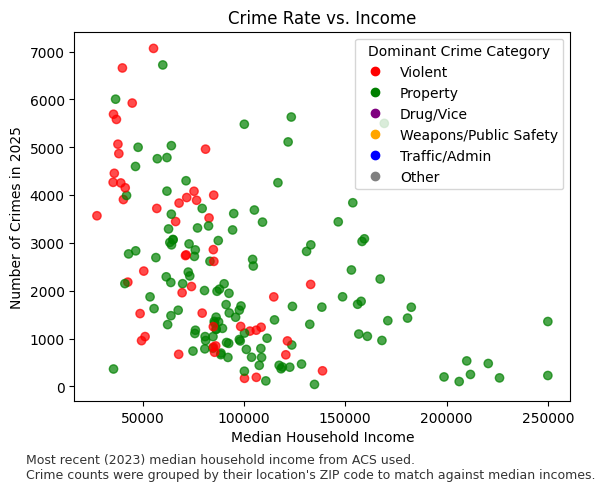

In [57]:
with open('zip_median.json', 'r') as file:
  zip_median = json.load(file)

x_vals = []
y_vals = []
c_vals = []

for zip, income in zip_median.items():
  subset = crime_data[crime_data['ZIP'] == zip]
  crime_count = len(subset)
  x_vals.append(income)
  y_vals.append(crime_count)
  
  dominant_category = subset["crime_group"].value_counts().idxmax()
  c_vals.append(colors[dominant_category])
  
plt.scatter(x_vals, y_vals, c=c_vals, alpha=0.7)
plt.title('Crime Rate vs. Income')
plt.xlabel('Median Household Income')
plt.ylabel('Number of Crimes in 2025')
plt.figtext(
  0.05, -.05,
  'Most recent (2023) median household income from ACS used.\n' +
  'Crime counts were grouped by their location\'s ZIP code to match against median incomes.',
  fontsize=9, c='#333333'
);

# legend_handles = [mpl.patches.Patch(color=color, label=cat) for cat, color in colors.items()]
legend_handles = [
    mpl.lines.Line2D([], [], color=color, marker='o', linestyle='None', label=cat)
    for cat, color in colors.items()
]
plt.legend(handles=legend_handles, title='Dominant Crime Category', loc='best')